# ANÁLISIS DE LOS RESULTADOS

***
<code> **PROYECTO NOVELLA** </code>

En este *notebook* se pretende evaluar el rendimiento de nuestro modelo final (MLP) con los nuevos datos obtenidos. Asimismo, implementaremos un modelo que se base en una heurística concreta y compararemos tanto a nivel global como por segmentos los resultados con los de nuestro modelo final.

## Importación de los datos
***

In [1]:
import pandas as pd

In [2]:
import os
import sys

# Añadimos la carpeta 'drive' al path
ruta_carpeta_drive = os.path.abspath('../drive')
if ruta_carpeta_drive not in sys.path:
    sys.path.insert(0, ruta_carpeta_drive)

import drive

In [3]:
# -- IMPORTAMOS FUNCIONES COMUNES --

from pathlib import Path

# Obtenemos la ruta al directorio del módulo utilidadesModelos.py
module_dir = Path("../modelos")

# Agregamos temporalmente el directorio al sys.path solo para esta importación
sys.path.append(str(module_dir))

from utilidadesModelos import *

In [4]:
df_train = pd.read_csv("train.csv", index_col = 0)
df_test = pd.read_csv("test_FINAL_EVALUACION.csv", index_col = 0)

In [5]:
df_train.head()

,Bestseller,NumPages,SagaNumber,RedPerc,BluePerc,BelongsSaga,Price,WordsTitle,PriceFormat,BookInterest1M,...,Womens,Womens Fiction,World War I,World War II,Young Adult,Young Adult Contemporary,Young Adult Fantasy,Young Adult Romance,Young Adult Science Fiction,Zombies
0,0.0,329.0,1.0,0.51,0.40,0,19.99,1.0,paperback,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,269.0,2.0,0.61,0.54,1,3.99,2.0,ebook,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,2335.0,1.0,0.72,0.57,1,20.99,7.0,ebook,0.0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,40.0,1.0,0.83,0.35,0,25.00,1.0,hardcover,0.0,...,0,0,0,0,1,0,0,0,0,0
4,0.0,189.0,1.0,0.59,0.26,0,15.00,4.0,paperback,0.0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df_test.head()

,Bestseller,NumPages,SagaNumber,RedPerc,BluePerc,BelongsSaga,Price,WordsTitle,PriceFormat,BookInterest1M,...,Womens,Womens Fiction,World War I,World War II,Young Adult,Young Adult Contemporary,Young Adult Fantasy,Young Adult Romance,Young Adult Science Fiction,Zombies
0,0.0,548.0,1.0,0.32,0.27,1,24.30,2.0,ebook,0.0,...,0,0,0,0,1,0,0,0,0,0
1,0.0,304.0,1.0,0.80,0.29,0,10.99,3.0,hardcover,0.0,...,0,0,0,0,1,0,0,0,0,0
2,0.0,352.0,1.0,0.39,0.35,0,18.00,3.0,paperback,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,336.0,1.0,0.13,0.13,1,17.99,2.0,paperback,0.0,...,0,0,0,0,1,0,1,0,0,0
4,0.0,232.0,1.0,0.87,0.20,1,13.99,2.0,hardcover,0.0,...,0,0,0,0,0,0,0,0,0,0


Separamos los conjuntos de datos en vectores X e y

In [7]:
y_train, X_train = getYX(df_train)
y_test, X_test = getYX(df_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3620, 310), (3620,), (327, 310), (327,))

## Transformación de los datos
***

### SMOTE-NC

In [8]:
from imblearn.over_sampling import SMOTENC
import numpy as np

In [9]:
# Columnas de los géneros
columnasGeneros = X_train.columns[13:]

# Columnas categóricas
categoricalColumns = ["BelongsSaga", "PriceFormat", 'HasTwitter', 'HasWikipedia'] + list(columnasGeneros)

# Definimos la transformación smote
smote = SMOTENC(categorical_features = categoricalColumns, random_state = SEED)

In [10]:
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
X_train_sm = redondearVariables(X_train_sm)
X_train_sm

,NumPages,SagaNumber,RedPerc,BluePerc,BelongsSaga,Price,WordsTitle,PriceFormat,BookInterest1M,Rating20Days,...,Womens,Womens Fiction,World War I,World War II,Young Adult,Young Adult Contemporary,Young Adult Fantasy,Young Adult Romance,Young Adult Science Fiction,Zombies
0,329.0,1.0,0.510000,0.400000,0,19.990000,1.0,paperback,0.000000,3.700000,...,0,0,0,0,0,0,0,0,0,0
1,269.0,2.0,0.610000,0.540000,1,3.990000,2.0,ebook,0.000000,3.890000,...,0,0,0,0,0,0,0,0,0,0
2,2335.0,1.0,0.720000,0.570000,1,20.990000,7.0,ebook,0.000000,4.450000,...,0,0,0,0,1,0,0,0,0,0
3,40.0,1.0,0.830000,0.350000,0,25.000000,1.0,hardcover,0.000000,4.300000,...,0,0,0,0,1,0,0,0,0,0
4,189.0,1.0,0.590000,0.260000,0,15.000000,4.0,paperback,0.000000,3.800000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,461.0,5.0,0.509583,0.491043,1,16.174499,3.0,paperback,1126.572964,4.471666,...,0,0,0,0,0,0,0,0,0,0
6266,297.0,1.0,0.542923,0.297848,1,13.442817,3.0,hardcover,1430.907779,4.307691,...,0,0,0,0,1,0,0,0,0,0
6267,453.0,1.0,0.467221,0.376106,1,15.948901,4.0,paperback,397.113488,4.101937,...,0,0,0,0,1,0,0,0,0,0
6268,253.0,1.0,0.178456,0.194228,0,9.201408,1.0,paperback,265.872490,3.003825,...,0,0,0,0,0,0,0,0,0,0


In [11]:
y_train_sm.value_counts()

Bestseller
0.0    3135
1.0    3135
Name: count, dtype: int64

### Escalado de variables
A continuación, vamos a realizar un escalado robusto a las variables numéricas.

In [12]:
from sklearn.preprocessing import RobustScaler

In [13]:
X_scaled_train = X_train_sm.copy()
X_scaled_test = X_test.copy()

# Inicializamos RobustScaler
scaler = RobustScaler()

# Solo lo aplicamos a las variables numéricas
variablesNumericas = ['SagaNumber', 'NumPages', 'RedPerc', 'BluePerc', 'Price', 'WordsTitle', 'BookInterest1M',
                     'Rating20Days', 'PrevBestSellAuthor']

# Aplicamos el RobustScaler a los datos de entrenamiento y test
X_scaled_train[variablesNumericas] = scaler.fit_transform(X_scaled_train[variablesNumericas])
X_scaled_test[variablesNumericas] = scaler.transform(X_scaled_test[variablesNumericas])

In [14]:
X_scaled_train[variablesNumericas].describe()

,SagaNumber,NumPages,RedPerc,BluePerc,Price,WordsTitle,BookInterest1M,Rating20Days,PrevBestSellAuthor
count,6270.000000,6270.000000,6.270000e+03,6.270000e+03,6270.000000,6270.000000,6270.000000,6.270000e+03,6270.000000
mean,1.585114,0.091164,2.543225e-02,6.586313e-02,0.189612,0.014195,1.751537,-7.404346e-02,1.145455
std,5.144154,1.194100,6.328342e-01,6.489474e-01,1.030033,0.742564,4.291946,7.717213e-01,4.402927
min,-1.333333,-3.515464,-1.395084e+00,-1.323571e+00,-3.142446,-1.000000,-0.714286,-4.903177e+00,0.000000
25%,0.000000,-0.474227,-4.833191e-01,-4.569045e-01,-0.394523,-0.500000,0.000000,-5.395405e-01,0.000000
50%,0.000000,0.000000,-8.163407e-17,9.248245e-17,0.000000,0.000000,0.000000,-1.009297e-15,0.000000
75%,1.000000,0.525773,5.166809e-01,5.430955e-01,0.605477,0.500000,1.000000,4.604595e-01,0.000000
max,76.000000,26.216495,1.487269e+00,1.776429e+00,8.430235,5.500000,20.078571,1.915005e+00,48.000000


### One-Hot Encoding

In [15]:
X_TRAIN = codificarPriceFormat(X_scaled_train)
X_TEST = codificarPriceFormat(X_scaled_test)

In [16]:
X_TRAIN.head()

,NumPages,SagaNumber,RedPerc,BluePerc,BelongsSaga,Price,WordsTitle,BookInterest1M,Rating20Days,HasTwitter,...,World War II,Young Adult,Young Adult Contemporary,Young Adult Fantasy,Young Adult Romance,Young Adult Science Fiction,Zombies,PriceFormat_ebook,PriceFormat_hardcover,PriceFormat_paperback
0,-0.237113,0.000000,0.075504,-0.023571,0,0.586878,-1.0,-0.714286,-1.039540,1.0,...,0,0,0,0,0,0,0,0,0,1
1,-0.855670,1.333333,0.369622,0.443096,1,-2.553606,-0.5,-0.714286,-0.607722,1.0,...,0,0,0,0,0,0,0,1,0,0
2,20.443299,0.000000,0.693151,0.543096,1,0.783158,2.0,-0.714286,0.665005,0.0,...,0,1,0,0,0,0,0,1,0,0
3,-3.216495,0.000000,1.016681,-0.190238,0,1.570242,-1.0,-0.714286,0.324096,1.0,...,0,1,0,0,0,0,0,0,1,0
4,-1.680412,0.000000,0.310799,-0.490238,0,-0.392560,0.5,-0.714286,-0.812268,0.0,...,0,0,0,0,0,0,0,0,0,1


In [17]:
X_TEST.head()

,NumPages,SagaNumber,RedPerc,BluePerc,BelongsSaga,Price,WordsTitle,BookInterest1M,Rating20Days,HasTwitter,...,World War II,Young Adult,Young Adult Contemporary,Young Adult Fantasy,Young Adult Romance,Young Adult Science Fiction,Zombies,PriceFormat_ebook,PriceFormat_hardcover,PriceFormat_paperback
0,2.020619,0.0,-0.483319,-0.456904,1,1.432846,-0.5,-0.714286,-0.016813,0.0,...,0,1,0,0,0,0,0,1,0,0
1,-0.494845,0.0,0.928446,-0.390238,0,-1.179644,0.0,-0.714286,0.005914,0.0,...,0,1,0,0,0,0,0,0,1,0
2,0.000000,0.0,-0.277437,-0.190238,0,0.196280,0.0,-0.714286,-1.607722,1.0,...,0,0,0,0,0,0,0,0,0,1
3,-0.164948,0.0,-1.042143,-0.923571,1,0.194317,-0.5,-0.714286,-0.130450,0.0,...,0,1,0,1,0,0,0,0,0,1
4,-1.237113,0.0,1.134328,-0.690238,1,-0.590803,-0.5,-0.714286,-1.494086,0.0,...,0,0,0,0,0,0,0,0,1,0


In [18]:
y_TRAIN = y_train_sm
y_TEST = y_test

## Recuperación del modelo MLP final
***

In [19]:
# Añadimos la carpeta 'drive' al path
ruta_carpeta_drive = os.path.abspath('../../drive')
if ruta_carpeta_drive not in sys.path:
    sys.path.insert(0, ruta_carpeta_drive)

# import descarga_archivos_GD
import drive

In [20]:
NOMBRE_DB = 'MLP_runs.db'
drive.descargar_archivos_concretos(NOMBRE_DB, '../drive')

Archivo MLP_runs.db guardado en: ./databases/MLP_runs.db


In [21]:
import mlflow.pyfunc
import sqlite3

In [22]:
# Función para cargar los hiperparámetros de un modelo

def load_model_from_db(database_name, run_id):
    """Dada una base de datos de SQLite y un Run ID devuelve los parámetros del modelo"""

    # Ruta completa de la base de datos en la carpeta "databases"
    db_path = os.path.join('databases', database_name)

    # Configuramos la URI del seguimiento de MLflow para que apunte a la base de datos SQLite
    mlflow.set_tracking_uri(f"sqlite:///{db_path}")

    # Conectamos con la base de datos SQLite
    conn = sqlite3.connect(db_path)
    
    # Obtenemos los hiperparámetros del modelo
    query = f"SELECT * FROM params WHERE run_uuid = '{run_id}'"
    params = conn.execute(query).fetchall()
    model_params = {param[0]: param[1] for param in params}

    return model_params

def clean_params(params):
    cleaned_params = {}
    for key, value in params.items():
        # Remove the 'classifier__' prefix from the key
        cleaned_key = key.replace('classifier__', '')
        
        # Convert specific string values to appropriate types
        if value.lower() == 'true':
            cleaned_params[cleaned_key] = True
        elif value.lower() == 'false':
            cleaned_params[cleaned_key] = False
        else:
            # Check if the value is in the form of a tuple
            if value.startswith('(') and value.endswith(')'):
                try:
                    # Convert the string representation of tuple to a tuple
                    tuple_value = tuple(map(int, value.strip('()').split(',')))
                    cleaned_params[cleaned_key] = tuple_value
                except ValueError:
                    cleaned_params[cleaned_key] = value
            else:
                # Try converting the value to a float
                try:
                    float_value = float(value)
                    # Convert to int if the float value has no decimals
                    if float_value.is_integer():
                        cleaned_params[cleaned_key] = int(float_value)
                    else:
                        cleaned_params[cleaned_key] = float_value
                # If conversion fails, keep the original value
                except ValueError:
                    cleaned_params[cleaned_key] = value
    return cleaned_params

In [23]:
from sklearn.neural_network import MLPClassifier

In [24]:
# Definimos la base de datos
mlp_database_name = 'MLP_runs.db'
mlp_run_id = '8c2da395658847e2b4c7ba6114ef8d60'

# Cargamos los parámetros
mlp_params = load_model_from_db(mlp_database_name, mlp_run_id)

# Creamos el modelo
MLP_model = MLPClassifier(**clean_params(mlp_params), random_state = SEED)

# Entrenamos el modelo
MLP_model.fit(X_TRAIN, y_TRAIN)
MLP_model

/Users/javimartinfuentes/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/javimartinfuentes/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/javimartinfuentes/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/javimartinfuentes/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/javimartinfuentes/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  

MLPClassifier(activation='logistic', alpha=0.8773407884629941,
              early_stopping=True, hidden_layer_sizes=(150, 150),
              learning_rate='adaptive',
              learning_rate_init=0.0023019050769459534, random_state=22)

## Análisis

### Modelo final

In [25]:
# Generamos las predicciones
MLP_pred = MLP_model.predict(X_TEST)

In [26]:
from sklearn.metrics import balanced_accuracy_score
baMLP = balanced_accuracy_score(y_TEST, MLP_pred)
sensibilidadMLP = sensitivity(y_TEST, MLP_pred)
especificidadMLP = specificity(y_TEST, MLP_pred)

In [27]:
data = {
    'Métrica': ['Balanced Accuracy', 'Sensibilidad', 'Especificidad'],
    'Valor': [baMLP, sensibilidadMLP, especificidadMLP]
}

df = pd.DataFrame(data)

df

,Métrica,Valor
0,Balanced Accuracy,0.714998
1,Sensibilidad,0.462963
2,Especificidad,0.967033


In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
def plot_confusion_matrix(cm, model_name):
    """
    Plots the confusion matrix using seaborn's heatmap.
    
    Parameters:
        cm (array): Confusion matrix.
        model_name (str): Name of the model.
    """
    plt.figure(figsize=(3, 2))
    sns.heatmap(cm, annot=True, cmap='Reds', fmt='g', cbar=False)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title(f'Matriz de confusión')
    plt.show()

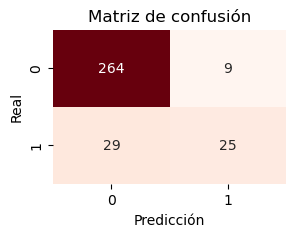

In [30]:
cm = confusion_matrix(y_TEST, MLP_pred)
plot_confusion_matrix(cm, "MLP FINAL")